In [1]:
! pip install xgboost
! pip install pandas
! pip install seaborn
! pip install xgboost
! pip install sklearn
! pip install catboost
! pip install umap-learn
! pip install eli5

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
  Using cached xgboost-1.2.0-py3-none-manylinux2010_x86_64.whl (148.9 MB)
  Using cached scipy-1.5.2-cp37-cp37m-manylinux1_x86_64.whl (25.9 MB)
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
  Using cached seaborn-0.11.0-py3-none-any.whl (283 kB)
     |████████████████████████████████| 11.6 MB 13.7 MB/s eta 0:00:01
  Using cached certifi-2020.6.20-py2.py3-none-any.whl (156 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (

In [29]:
import pandas as pd
from sklearn.model_selection import KFold
import numpy as np
import seaborn as sns
import xgboost as xgb
import math
import time
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from catboost import CatBoostRegressor
import eli5
from eli5.sklearn import PermutationImportance
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [21]:
def get_k_folds_by_column(dataset, k_folds_count = 10, column = 'Patient_ID'):
    test_set_count = math.floor(len(dataset) / k_folds_count)
    arrays_by_patient_id = [pd.DataFrame(y) for x, y in dataset.groupby(column, as_index=False)]

    test_users = []
    indices = []
    current_user_index = 0

    for i in range(k_folds_count):
        current_row_length = 0
        current_test_users = []
        while current_row_length < test_set_count and current_user_index != len(arrays_by_patient_id):
            user_to_add = arrays_by_patient_id[current_user_index]
            current_test_users.append(user_to_add.iloc[0][column])
            current_row_length += len(user_to_add)
            current_user_index += 1

        test_users.append(current_test_users)
        indices.append([~dataset[column].isin(current_test_users), dataset[column].isin(current_test_users)])
    
    return indices
    

In [33]:
data = pd.read_csv('Osmolarity.csv')
data = data[['Osmolarity (vein)', 'Glu (vein)', 'Na + (vein)', 'ctO2 (vein)', 'Cl- (vein)', 'Lac (vein)', 'Patient_ID']]

folds = get_k_folds_by_column(data)

data_test = data.drop(columns=['Patient_ID'])
research_feature = 'Osmolarity (vein)'
x_data = data_test.drop(columns=[research_feature])
y_data = data_test[research_feature]

13534
1986
0.9576298062403606
13965
1555
0.8923049046163013
13967
1553
0.8092167138205386
13966
1554
0.7911151649446221
13963
1557
0.9645761595909407
13963
1557
0.854809589253307
13968
1552
0.9815142561012203
13945
1575
0.9101097581712041
13905
1615
0.9907583335856063
14504
1016
0.9817115255783965
mse: 12.65362631642272
mae: 0.8166158316968254
r^2: 0.9133746211902496


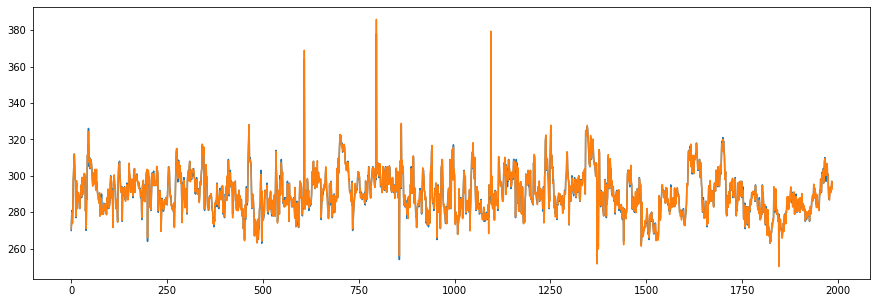

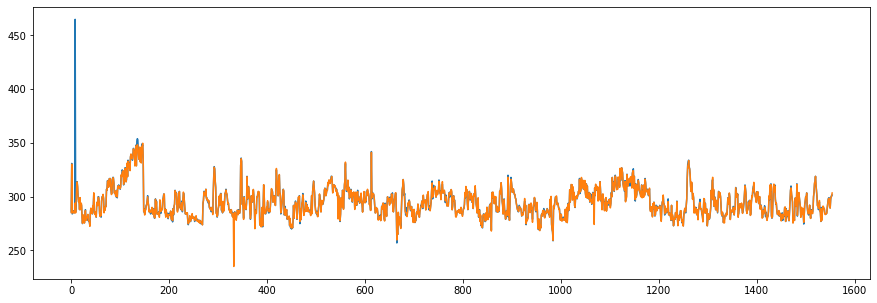

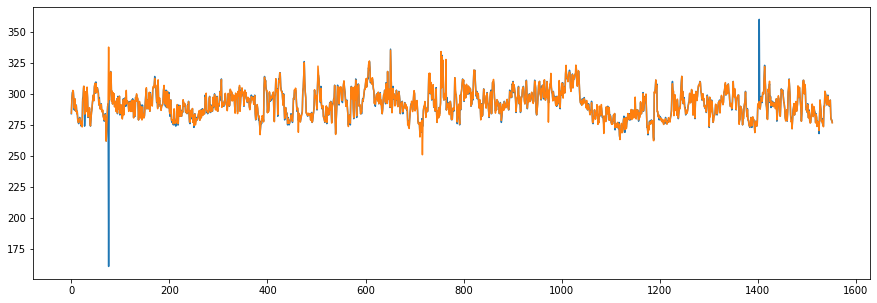

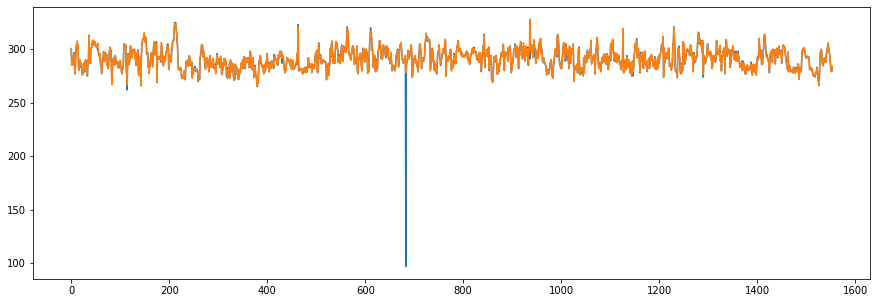

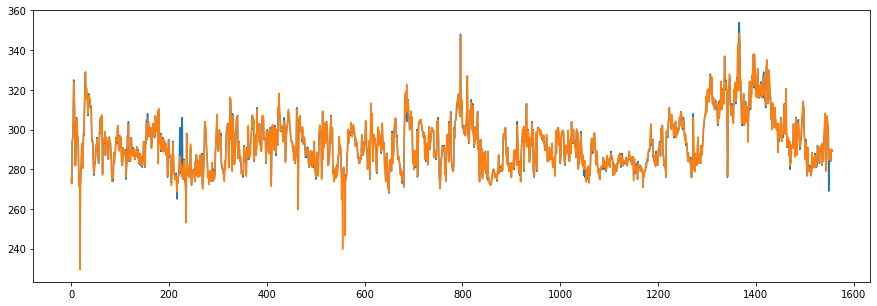

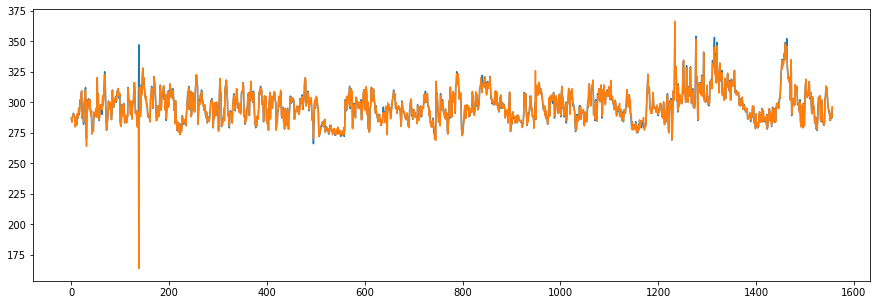

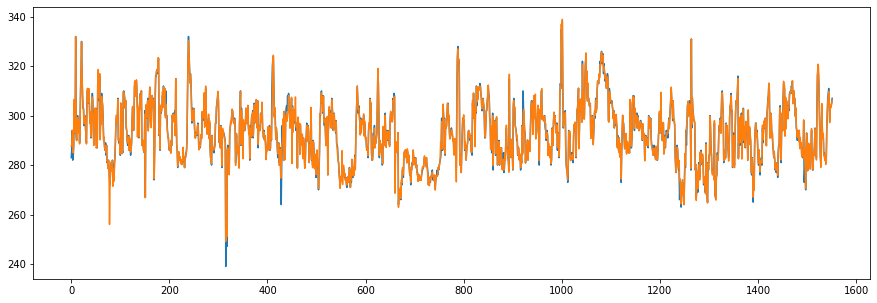

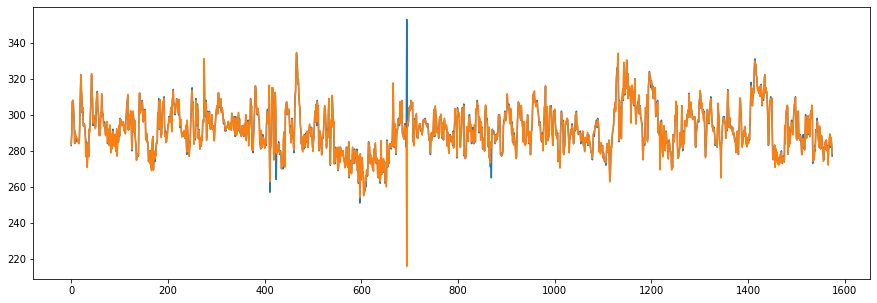

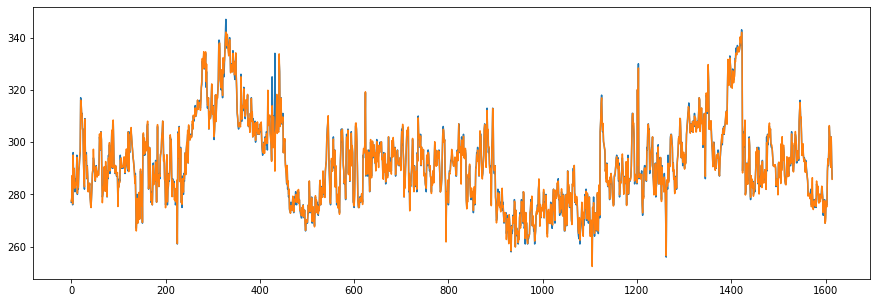

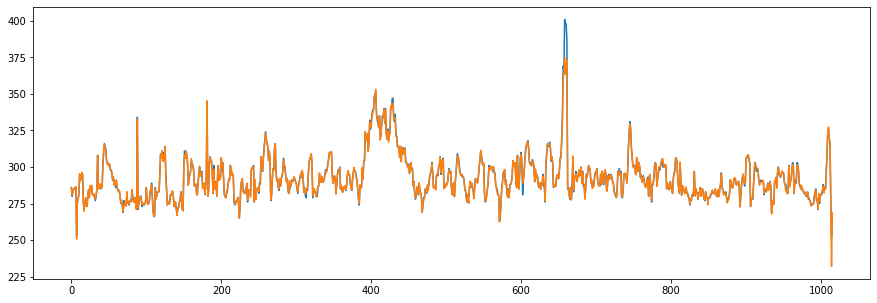

In [34]:
def regressionAlgorithmCustomKFolds(regressor, x_data, y_data, dataframe):
    folds = get_k_folds_by_column(dataframe)
    mse_array = []
    mae_array = []
    r2_array = []

    x_np = np.array(x_data)
    y_np = np.array(y_data)

    for train_index, test_index in folds:
        x_train, x_test = x_np[train_index], x_np[test_index]
        y_train, y_test = y_np[train_index], y_np[test_index]
        x_train_s = x_train
        x_test_s = x_test
        print(len(x_train_s))
        print(len(x_test_s))
        regressor.fit(x_train_s, y_train)
        y_pred = regressor.predict(x_test_s)
        plt.figure(figsize=(15,5)) 
        plt.plot(y_test.tolist(), label='Y test')
        plt.plot(y_pred, label='XGBoost')
        mse_array.append(sklearn.metrics.mean_squared_error(y_test, y_pred))
        mae_array.append(sklearn.metrics.mean_absolute_error(y_test, y_pred))
        r2 = sklearn.metrics.r2_score(y_test, y_pred)
        print(r2)
        r2_array.append(r2)

    print('mse:', np.mean(mse_array))
    print('mae:', np.mean(mae_array))
    print('r^2:', np.mean(r2_array))

regressionAlgorithmCustomKFolds(xgb.XGBRegressor(random_state=42), x_data, y_data, data)

In [49]:
# df = df[['Osmolarity (vein)', 'Glu (vein)', 'Na + (vein)', 'ctO2 (vein)', 'pH (vein)', 'Lac (vein)']]
df = df.drop_duplicates()
research_feature = 'Glu (vein)'
X = df.drop(columns=[research_feature])
print(df.shape)
y = df[research_feature]
# print(y.value_counts())
# print(df['Osmolarity (vein)'].value_counts())
# print(df['Na + (vein)'].value_counts())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train_s = preprocessing.normalize(X_train)
X_test_s = preprocessing.normalize(X_test)


(15257, 28)


In [50]:
def regressionAlgorithm(regressor):
    kfold = KFold(n_splits=10, shuffle=True)
    mse_array = []
    mae_array = []
    r2_array = []

    x_np = np.array(X)
    y_np = np.array(y)
    
    for train_index, test_index in kfold.split(x_np, y_np):
        x_train, x_test = x_np[train_index], x_np[test_index]
        y_train, y_test = y_np[train_index], y_np[test_index]
        x_train_s = preprocessing.normalize(x_train)
        x_test_s = preprocessing.normalize(x_test)
        regressor.fit(x_train_s, y_train)
        y_pred = regressor.predict(x_test_s)
        plt.figure(figsize=(15,5)) 
        plt.plot(y_test.tolist(), label='Y test')
        plt.plot(y_pred, label='XGBoost')
        mse_array.append(sklearn.metrics.mean_squared_error(y_test, y_pred))
        mae_array.append(sklearn.metrics.mean_absolute_error(y_test, y_pred))
        r2 = sklearn.metrics.r2_score(y_test, y_pred)
        print(r2)
        r2_array.append(r2)

    print('mse:', np.mean(mse_array))
    print('mae:', np.mean(mae_array))
    print('r^2:', np.mean(r2_array))
    

In [ ]:
regressionAlgorithm(xgb.XGBRegressor(random_state=42))

In [56]:
def permutationImportance(regressor, x, y, columns, df):
    regressor.fit(x, y)
    perm = PermutationImportance(regressor, random_state=42).fit(x, y)
    exp = eli5.explain_weights(perm, feature_names=columns.tolist(), top=None)
    weights_dataframe = eli5.formatters.as_dataframe.format_as_dataframe(exp)
    weights_dataframe.to_csv('PermutationImportance' + str(math.ceil(time.time() % 100000)) + '.csv')
    print('Completed')

In [61]:
permutationImportance(xgb.XGBRegressor(random_state=42), np.array(X), np.array(y), X.columns, df)

Completed


In [62]:
regressor = CatBoostRegressor(silent=True, random_state=42, n_estimators=1000)
permutationImportance(regressor, np.array(X), np.array(y), X.columns, df)

Completed


In [29]:
# xgboost_model = xgb.XGBRegressor(random_state=42, max_depth=3, n_estimators=1000)
xgboost_model = xgb.XGBRegressor(random_state=42)
xgboost_model.fit(X_train_s, y_train)
xgboost_y = xgboost_model.predict(X_test_s)

mse: 7.243434418279964e+30
mae: 479420259092789.06
r^2: -0.4095863941114293


[(0.45520985, 'Glu (vein)'),
 (0.3885319, 'ctO2 (vein)'),
 (0.09297354, 'Lac (vein)'),
 (0.06328474, 'pH (vein)')]

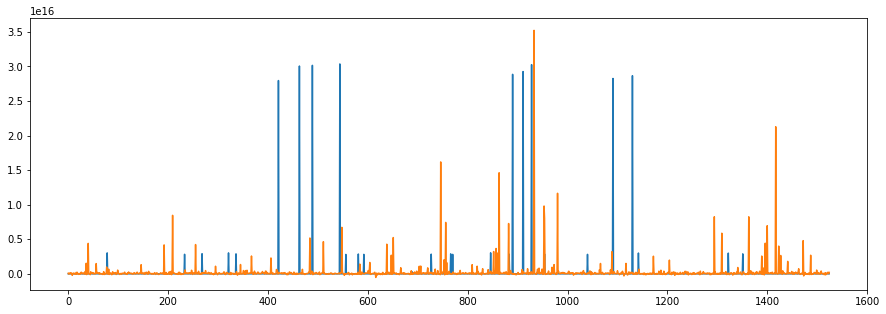

In [30]:
plt.figure(figsize=(15,5)) 
plt.plot(y_test.tolist(), label='Y test')
plt.plot(xgboost_y, label='XGBoost')
print('mse:', sklearn.metrics.mean_squared_error(y_test, xgboost_y))
print('mae:', sklearn.metrics.mean_absolute_error(y_test, xgboost_y))
print('r^2:', sklearn.metrics.r2_score(y_test, xgboost_y))
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:f}'.format})
imp = xgboost_model.feature_importances_
feat = {}
for i in range(len(X_train.columns)):
    feat[X_train.columns[i]] = imp[i]
    
sorted( ((k,v) for v,k in feat.items()), reverse=True) 

In [26]:
model = CatBoostRegressor(silent=True, random_state=42, n_estimators=1000)
# model = CatBoostRegressor(silent=True, random_state=42)
model.fit(X_train_s, y_train)
catboost_y = model.predict(X_test_s)

mse: 2.643151028265868e+29
mae: 48817188452704.46
r^2: 0.9485637680708108


[(27.864150386465163, 'Lac (vein)'),
 (27.34441184912, 'pH (vein)'),
 (24.32271382922019, 'ctO2 (vein)'),
 (19.807036369744534, 'Glu (vein)'),
 (0.6616875654501186, 'Na + (vein)')]

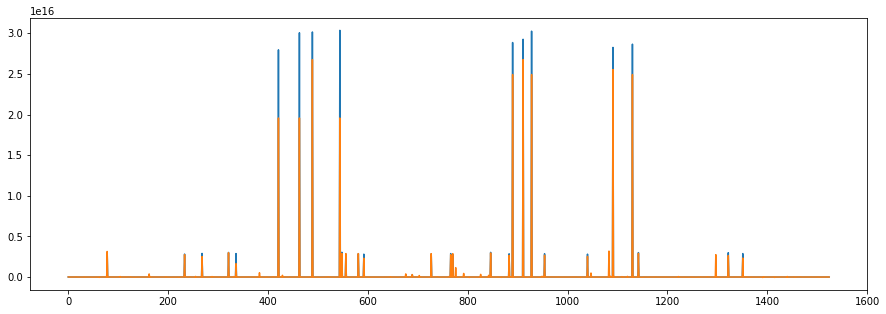

In [27]:
plt.figure(figsize=(15,5))
plt.plot(y_test.tolist(), label='Y test')
plt.plot(catboost_y, label='CatBoost')
print('mse:', sklearn.metrics.mean_squared_error(y_test, catboost_y))
print('mae:', sklearn.metrics.mean_absolute_error(y_test, catboost_y))
print('r^2:', sklearn.metrics.r2_score(y_test, catboost_y))
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:f}'.format})
imp = model.get_feature_importance()
feat = {}
for i in range(len(X_train.columns)):
    feat[X_train.columns[i]] = imp[i]
    
sorted( ((k,v) for v,k in feat.items()), reverse=True) 

In [71]:
from sklearn.model_selection import GridSearchCV, KFold

cv = KFold(n_splits=10, shuffle=True, random_state=42)
params_grid = {
    'n_estimators': [60, 100, 180, 300, 500, 1000]
}

model = CatBoostRegressor(silent=True, random_state=42)
grid_model = GridSearchCV(model, params_grid, cv=cv, scoring='neg_mean_squared_error')
grid_model.fit(X_train, y_train)
y_pred = grid_model.predict(X_test)

mse: 0.8374064716346705
mae: 0.624301923601688
r^2: 0.9450260731237791


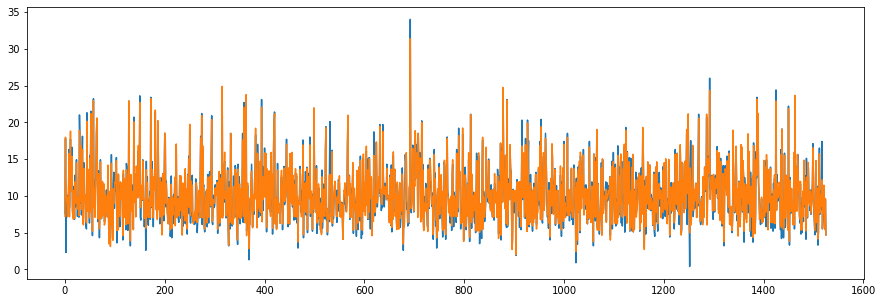

In [72]:
plt.figure(figsize=(15,5)) 
plt.plot(y_test.tolist(), label='Y test')
plt.plot(y_pred, label='XGBoost')
print('mse:', sklearn.metrics.mean_squared_error(y_test, y_pred))
print('mae:', sklearn.metrics.mean_absolute_error(y_test,y_pred))
print('r^2:', sklearn.metrics.r2_score(y_test, y_pred))
imp = model.get_feature_importance()
for i in range(len(df.columns)):
    print(df.columns[i], imp[i])

In [73]:
grid_model.best_params_

{'n_estimators': 1000}

In [60]:
from sklearn.model_selection import GridSearchCV, KFold

model = xgb.XGBRegressor(random_state=42, nthread=-1, n_estimators=1000)
model.fit(X_train, y_train)
y_pred = grid_model.predict(X_test)

array([0.00225673, 0.00198019, 0.00125848, 0.00213049, 0.00291465,
       0.00681616, 0.00159439, 0.00355769, 0.00512588, 0.00497744,
       0.00311055, 0.00425973, 0.00450933, 0.00472835, 0.00654494,
       0.00423775, 0.00625661, 0.00532759, 0.00502311, 0.43077028,
       0.00360683, 0.00845669, 0.05446847, 0.38585818, 0.03209466,
       0.00289047, 0.00524436], dtype=float32)

In [65]:
df.columns[23]

'Lac (vein)'

In [70]:
df.corr()

,Sex,Smoke_status,SBE (vein),"HCO3- (P, st) (vein)",FCOHb (vein),FHHb (vein),FMetHb (vein),FHbF (vein),F02Hb (vein),ctBil (vein),...,K + (vein),Na + (vein),Ca2 + ( vein),Cl- (vein),Glu (vein),Lac (vein),Osmolarity (vein),ctO2 (vein),p50 (vein),Age
Sex,1.000000,0.391671,-0.027804,0.001722,-0.014384,0.030907,-0.018250,-0.085212,-0.017188,-0.052450,...,0.017445,-0.030706,-0.030979,-0.029686,-0.061251,-0.030159,-0.026996,0.064287,-0.033811,-0.245026
Smoke_status,0.391671,1.000000,0.041181,0.027275,0.023669,0.020617,0.042094,-0.061652,0.015880,-0.014731,...,-0.013524,-0.023658,-0.093517,-0.023713,-0.062361,-0.059931,-0.021646,0.082244,-0.021764,-0.221986
SBE (vein),-0.027804,0.041181,1.000000,0.594072,0.453927,0.431169,0.382887,-0.001191,0.472115,0.203458,...,0.021874,-0.014721,-0.017654,-0.014904,-0.036016,-0.021610,-0.013492,0.029620,-0.386850,-0.027904
"HCO3- (P, st) (vein)",0.001722,0.027275,0.594072,1.000000,0.903432,0.891238,0.814680,0.144951,0.962211,0.445920,...,0.087729,-0.027342,-0.063122,-0.027517,-0.013749,0.018693,-0.024760,0.002667,-0.722342,0.056719
FCOHb (vein),-0.014384,0.023669,0.453927,0.903432,1.000000,0.790736,0.730711,0.076264,0.899351,0.460687,...,0.084281,-0.022355,-0.059735,-0.022312,-0.016637,0.004910,-0.019916,0.007560,-0.631243,0.085501
FHHb (vein),0.030907,0.020617,0.431169,0.891238,0.790736,1.000000,0.725318,0.086210,0.781451,0.446373,...,0.073612,-0.025375,-0.060881,-0.025562,-0.018886,0.036274,-0.023020,-0.095064,-0.666913,0.055208
FMetHb (vein),-0.018250,0.042094,0.382887,0.814680,0.730711,0.725318,1.000000,0.151991,0.813529,0.488980,...,0.088127,-0.027163,-0.095398,-0.027330,0.004840,0.047224,-0.024580,0.017469,-0.575690,0.066462
FHbF (vein),-0.085212,-0.061652,-0.001191,0.144951,0.076264,0.086210,0.151991,1.000000,0.194895,0.070358,...,0.047559,-0.002609,0.033504,-0.002548,0.020988,-0.011226,-0.002119,-0.085294,0.035489,0.052233
F02Hb (vein),-0.017188,0.015880,0.472115,0.962211,0.899351,0.781451,0.813529,0.194895,1.000000,0.430426,...,0.097638,-0.026019,-0.059039,-0.026121,0.000887,0.034601,-0.023456,0.040538,-0.691013,0.075397
ctBil (vein),-0.052450,-0.014731,0.203458,0.445920,0.460687,0.446373,0.488980,0.070358,0.430426,1.000000,...,0.063143,-0.015989,0.006581,-0.016135,-0.032424,0.143611,-0.014540,-0.010664,-0.335634,0.083910


In [98]:
correlation_matrix = df.corr()
correlated_features = []
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.append(colname)

In [99]:
np.unique(correlated_features)

array(['Cl- (vein)', 'F02Hb (vein)', 'FCOHb (vein)', 'FHHb (vein)',
       'FMetHb (vein)', 'HCO3- (P) (vein)', 'Na + (vein)',
       'Osmolarity (vein)', 'ctHb (vein)', 'pCO2 (vein)'], dtype='<U17')

In [105]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)
# access values and vectors
print(pca.components_)
print(pca.explained_variance_)

[[-2.88119838e-18 -3.25294196e-16  4.82657814e-18 -5.00170300e-17
  -1.56239902e-18 -6.97066024e-17 -2.28228303e-18 -5.10648563e-19
  -1.31423327e-16 -4.92351162e-17  1.02908243e-19  1.06031289e-01
   1.23842156e-01  7.04605593e-18  7.31692073e-02  1.18463294e-01
   2.82021318e-01 -9.74028772e-20 -3.81979786e-19  3.93396809e-01
   3.55880020e-19  2.90629006e-01  7.62399454e-19  7.97038838e-01
  -2.15629418e-18  4.85475081e-17 -2.93238002e-17]
 [ 2.54134841e-17  2.86343514e-16  3.65539839e-16  2.43542038e-16
   2.27651398e-17  4.29547472e-16  1.40707614e-17  3.47598075e-18
   7.96915587e-16  3.01410249e-16 -5.65089417e-19 -8.28064068e-02
  -1.13461356e-01 -2.37234140e-17 -6.45723956e-02 -4.85100448e-01
  -3.86917803e-01  9.82100038e-20 -4.03748704e-18 -4.26281761e-01
  -1.23197775e-18 -3.01944126e-01  1.88097795e-18  5.64079603e-01
  -9.91373139e-17 -5.54052607e-16  1.89794701e-16]
 [ 1.28276922e-17 -1.67685850e-16  2.59959573e-16  7.49965422e-17
   2.63470607e-17  4.55759998e-17  1.022

In [12]:
import umap
reducer = umap.UMAP(n_components=27)

rofl = reducer.fit_transform(X)


In [14]:
rofl[0]

array([8.354322 , 4.6913195, 5.237167 , 2.8748038, 4.354326 , 4.946024 ,
       0.9924425, 4.6134877, 4.7851534, 5.0513077, 4.6745367, 5.1380906,
       5.011867 , 5.1826344, 5.3045416, 4.914797 , 4.6037893, 4.9386888,
       4.3845983, 5.8769903, 5.281798 , 5.5440426, 4.838081 , 4.6636434,
       4.234932 , 5.1081333, 5.223303 ], dtype=float32)